In [52]:
import pandas as pd
import pathlib
import geopandas as gpd
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import seaborn as sbn
import cartopy.crs as ccrs

# Load the input data

In [53]:
base_path = pathlib.Path("/Users/fabriziofinozzi/Desktop/OpenEnergyTransition/repo/")
base_network_pypsa_earth = pypsa.Network(pathlib.Path(base_path, "geothermal-modelling/workflow/pypsa-earth/networks/US_2021/base.nc"))
base_network_pypsa_usa = pypsa.Network(pathlib.Path(base_path, "pypsa-usa/workflow/resources/Default/usa/elec_base_network.nc"))
eia_base_network = gpd.read_file(pathlib.Path(base_path, "geothermal-modelling/analysis/data/US_Electric_Power_Transmission_Lines_5037807202786552385.geojson"))

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

In [54]:
eia_base_network

,OBJECTID_1,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,GlobalID,geometry
0,1,1,100511,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 861, EIA 860","Tue, 08 Nov 2016 00:00:00 GMT",Imagery,"Mon, 27 Mar 2017 00:00:00 GMT",Not Available,115.0,100-161,Yes,Waters River,Tap136228,79.523416,f1500a3a-804a-4da4-b6f6-bd0fbb2cf36d,"LINESTRING (-70.92855 42.54359, -70.92841 42.5..."
1,2,2,140809,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 860","Wed, 16 Apr 2014 00:00:00 GMT",Imagery,"Wed, 15 Feb 2017 00:00:00 GMT",Kingsport Power Co,161.0,100-161,Yes,Phillips Bend,John Sevier,24018.513114,58c24e54-d758-4071-9ebf-d83beb60c707,"LINESTRING (-82.96123 36.37699, -82.96090 36.3..."
2,3,3,140837,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, https://www9.nationalgridus.com/oasis...","Tue, 16 Jun 2015 00:00:00 GMT",Imagery,"Tue, 05 Mar 2019 00:00:00 GMT",Niagara Mohawk Power Corp.,115.0,100-161,Yes,Tap140359,Tap140373,5972.919614,c40bbff1-b1ed-4905-9ff6-1a80b7b422fc,"LINESTRING (-75.33407 43.08946, -75.33426 43.0..."
3,4,4,140811,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, OpenStreetMap","Fri, 20 Jun 2014 00:00:00 GMT",Imagery,"Mon, 20 Mar 2017 00:00:00 GMT","Entergy New Orleans, Llc",115.0,100-161,Yes,Gentilly Road,Michoud Station,14253.092823,f09483e3-5419-4b94-aac5-a6450f2452c4,"LINESTRING (-89.93728 30.00905, -89.93773 30.0..."
4,5,5,140813,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 860","Tue, 04 Oct 2016 00:00:00 GMT",Imagery/other,"Wed, 09 May 2018 00:00:00 GMT",Midamerican Energy Co,161.0,100-161,Yes,Unknown137689,Tap137690,8950.844317,36ac4f5e-ad18-47c2-bb7d-8ba64b7fa822,"LINESTRING (-90.56609 41.61256, -90.56468 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94211,94212,94212,313969,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,Imagery,"Tue, 28 Aug 2018 00:00:00 GMT",Imagery/other,"Tue, 24 May 2022 00:00:00 GMT",Sulphur Springs Valley Electric Cooperative,69.0,Under 100,No,Tap302103,Stewart,14234.316259,e2d37fb1-dca0-406f-9033-d692f5f4bc99,"LINESTRING (-109.87545 32.23874, -109.87542 32..."
94212,94213,94213,313970,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,Imagery,"Tue, 16 Oct 2018 00:00:00 GMT",Imagery/other,"Tue, 24 May 2022 00:00:00 GMT",Graham County Electric Cooperative Incorporated,69.0,Under 100,No,Tap300244,Hackberry,25444.741067,3c2f7c5c-728d-4ce3-b663-c2555474b534,"LINESTRING (-109.60459 32.87502, -109.61015 32..."
94213,94214,94214,202495,AC; Overhead,Not Available,221121,Electric Bulk Power Transmission and Control,Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",City Of Gering - (Ne),115.0,100-161,No,Tap204261,Unknown202234,106510.794263,00225744-4cf6-4f33-9d8a-6f458515cad8,"LINESTRING (-104.45345 42.05791, -104.45308 42..."
94214,94215,94215,202496,AC; Overhead,Not Available,221121,Electric Bulk Power Transmission and Control,Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",City Of Gering - (Ne),115.0,100-161,No,Tap161754,Tap204258,49097.232454,17d49594-e00f-4a93-b602-fe5992196552,"LINESTRING (-103.87027 41.81278, -103.87065 41..."


The total number of lines in the EIA dataset is

In [55]:
eia_base_network.shape[0]

94216

At first glance, it is possible to see that some transmission lines correspond to a voltage of -999999.0 kV. In particular the number of lines corresponding to -999999.0 is

In [56]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]

14062

which acoounts for almost 15 % of the lines in the EIA dataset

In [57]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]/eia_base_network.shape[0]*100

14.9252780844018

For the moment, such lines are filtered out

In [58]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLTAGE"]!=-999999.0]
eia_base_network.shape[0]

80154

Get the voltage bins from the reference data

In [59]:
eia_voltage_bins_flags = eia_base_network["VOLT_CLASS"].unique().tolist()
eia_voltage_bins_flags

['100-161',
 'Under 100',
 '345',
 '220-287',
 '500',
 '735 And Above',
 'Dc',
 'Not Available']

In [60]:
volt_class_min_values = []
volt_class_max_values = []
for bin_name in eia_voltage_bins_flags:
    volt_class_min_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].min())
    volt_class_max_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].max())
volt_class_bin_limits = pd.DataFrame(
    {
        "voltage_class": eia_voltage_bins_flags,
        "voltage_class_min": volt_class_min_values,
        "voltage_class_max": volt_class_max_values,
    }
)
volt_class_bin_limits

,voltage_class,voltage_class_min,voltage_class_max
0,100-161,100.0,218.0
1,Under 100,3.0,92.0
2,345,345.0,345.0
3,220-287,220.0,287.0
4,500,500.0,500.0
5,735 And Above,765.0,765.0
6,Dc,200.0,1000.0
7,Not Available,169.0,169.0


The voltage classes in the EIA dataset include also *Dc*. The number of lines corresponding to such voltage class is

In [61]:
eia_base_network.loc[eia_base_network["VOLT_CLASS"]=='Dc'].shape[0]

9

Considering that the PyPSA-Earth base network does not contain any DC line

In [62]:
base_network_pypsa_earth.lines["dc"].unique()

array([False])

the lines corresponding to the *Dc* voltage class are removed from the EIA dataset

In [63]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Dc']
eia_base_network.shape[0]

80145

Furthermore, the lines corresponding to the voltage class *Not Available* are removed as well

In [64]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Not Available']
eia_base_network.shape[0]

80144

# PyPSA-Earth - EIA comparison

Add the voltage class to the PyPSA-Earth base network

In [65]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom"]
base_network_pypsa_earth.lines

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
2,line,115.0,1.0,50.0,6845,14907,52.037753,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
3,line,115.0,1.0,50.0,2696,567,54.958156,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
4,line,115.0,1.0,50.0,6847,2696,120.709508,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24040,cable,69.0,1.0,50.0,1207,1229,1.219578,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0
24041,cable,138.0,1.0,50.0,625,2154,24.275706,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0
24042,cable,70.0,1.0,60.0,10399,15899,14.348862,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0


In [66]:
v_nom_class_dict_pypsa_earth = {
    55.: 'Under 100',
    57.1: 'Under 100', 
    60.: 'Under 100',
    66.: 'Under 100',  
    69.: 'Under 100',  
    70.: 'Under 100',  
    88.: 'Under 100', 
    92.: 'Under 100', 
    100.: "100-161",
    115.: "100-161", 
    120.: "100-161",  
    125.: "100-161",  
    138.: "100-161",  
    160.: "100-161",  
    161.: "100-161",
    220.: "220-287",
    230.: "220-287",
    287.: "220-287",
    345.: "345",
    500.: "500",
    765.: "735 And Above"
}

In [67]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom_class"].replace(v_nom_class_dict_pypsa_earth)
base_network_pypsa_earth.lines

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
2,line,115.0,1.0,50.0,6845,14907,52.037753,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
3,line,115.0,1.0,50.0,2696,567,54.958156,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
4,line,115.0,1.0,50.0,6847,2696,120.709508,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24040,cable,69.0,1.0,50.0,1207,1229,1.219578,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Under 100
24041,cable,138.0,1.0,50.0,625,2154,24.275706,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
24042,cable,70.0,1.0,60.0,10399,15899,14.348862,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Under 100


### Count plot

[Text(0.5, 1.0, 'PyPSA-Earth base network')]

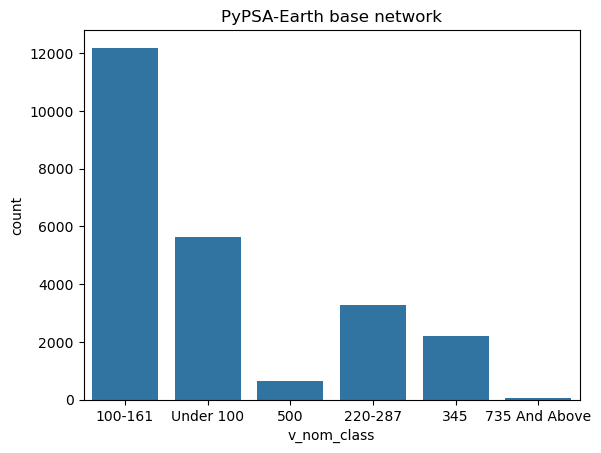

In [68]:
sbn.countplot(data=base_network_pypsa_earth.lines, x=base_network_pypsa_earth.lines["v_nom_class"]).set(title='PyPSA-Earth base network')

[Text(0.5, 1.0, 'EIA network topology')]

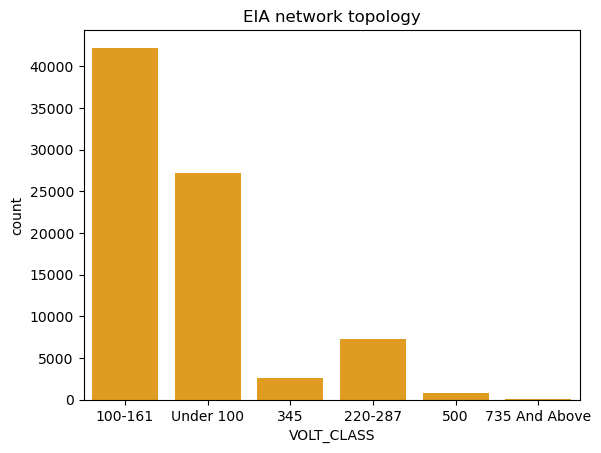

In [69]:
sbn.countplot(data=eia_base_network, x=eia_base_network["VOLT_CLASS"], color="orange").set(title='EIA network topology')

### Maps

In [70]:
# Available voltage classes are:
# Under 100
# 100-161
# 220-287
# 345
# 500
# 735 And Above

selected_voltage_class_earth = "735 And Above"

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


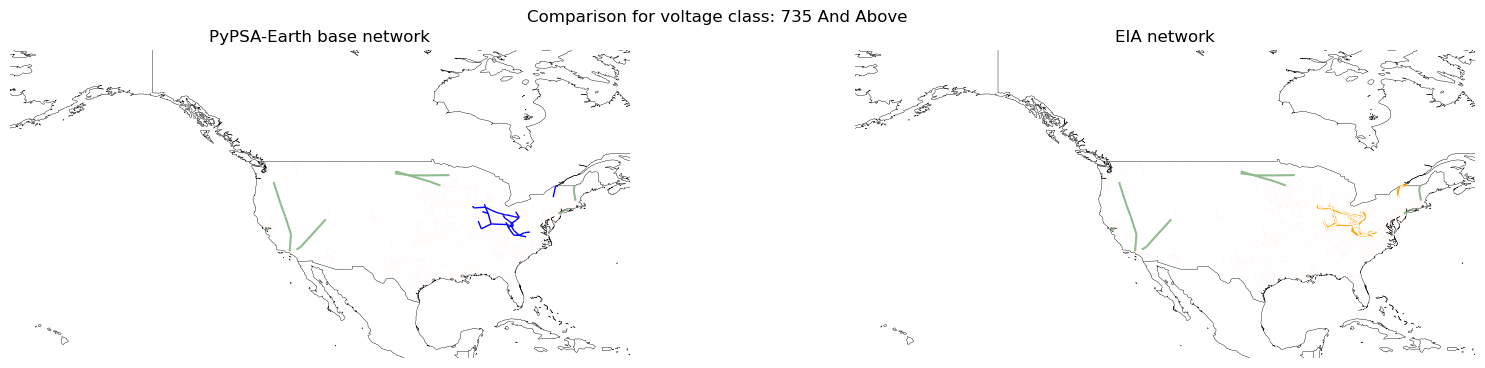

In [71]:
base_network_pypsa_earth.lines["line_width"] = 0.0
base_network_pypsa_earth.lines.loc[base_network_pypsa_earth.lines["v_nom_class"] == selected_voltage_class_earth, "line_width"] = 1.0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, subplot_kw={"projection":ccrs.PlateCarree(), "projection":ccrs.PlateCarree()}, figsize=(20, 4))
base_network_pypsa_earth.plot(line_widths = base_network_pypsa_earth.lines["line_width"], bus_sizes = 0, line_colors = "blue", ax=ax1)
base_network_pypsa_earth.plot(line_widths = base_network_pypsa_earth.lines["line_width"], bus_sizes = 0, line_colors = "white", ax=ax2)
eia_base_network.loc[eia_base_network["VOLT_CLASS"]==selected_voltage_class_earth].plot(ax=ax2, color="orange")
fig.suptitle("Comparison for voltage class: {}".format(selected_voltage_class_earth))
ax1.set_aspect('equal')
ax1.title.set_text("PyPSA-Earth base network")
ax2.set_aspect("equal")
ax2.title.set_text("EIA network")

In [72]:
fig.savefig("network_comparison_for_voltage_class_{}.png".format(str(selected_voltage_class_earth)))

# PyPSA-USA - EIA comparison

Add the voltage class to the PyPSA-USA base network

In [73]:
base_network_pypsa_usa.lines["v_nom_class"] = base_network_pypsa_usa.lines["v_nom"]
base_network_pypsa_usa.lines

,bus0,bus1,r,x,b,s_nom,v_nom,interconnect,type,carrier,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,
1,1,5,0.118496,0.567617,0.000000e+00,0.00,230.0,Eastern,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
2,1,6,0.107916,0.545399,0.000000e+00,0.00,230.0,Eastern,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
4,170,2,0.833307,4.153708,3.962193e-07,186.85,115.0,Eastern,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
6,234,5,0.899300,6.955821,4.497164e-07,531.98,230.0,Eastern,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
7,5,874,0.836349,7.498575,1.166541e-06,600.42,230.0,Eastern,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSW_export_3008706,3008706,OSW_POI_3008706,0.100000,0.100000,0.000000e+00,0.00,230.0,Western,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
OSW_export_3008707,3008707,OSW_POI_3008707,0.100000,0.100000,0.000000e+00,0.00,230.0,Western,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
OSW_export_3008708,3008708,OSW_POI_3008708,0.100000,0.100000,0.000000e+00,0.00,230.0,Western,Al/St 240/40 2-bundle 220.0,AC,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0


In [74]:
base_network_pypsa_usa.lines.v_nom.unique()

array([230., 115., 500., 161., 138., 100., 345.,  69., 765.])

In [75]:
v_nom_class_dict_pypsa_usa = {
    69.: 'Under 100',
    100.: "100-161",
    138.: "100-161", 
    115.: "100-161", 
    161.: "100-161",
    230.: "220-287",
    345.: "345",
    500.: "500",
    765.: "735 And Above"
}

In [76]:
base_network_pypsa_usa.lines["v_nom_class"] = base_network_pypsa_usa.lines["v_nom_class"].replace(v_nom_class_dict_pypsa_usa)

### Maps

In [77]:
# Available voltage classes are:
# Under 100
# 100-161
# 220-287
# 345
# 500
# 735 And Above

selected_voltage_class_usa = "735 And Above"

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


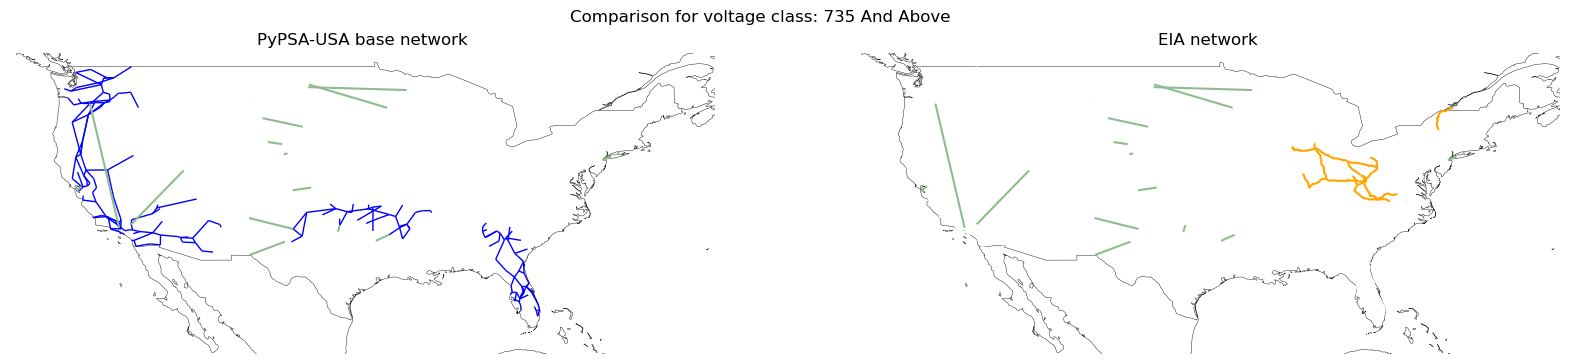

In [78]:
base_network_pypsa_usa.lines["line_width"] = 0.0
base_network_pypsa_usa.lines.loc[base_network_pypsa_usa.lines["v_nom_class"] == selected_voltage_class_usa, "line_width"] = 1.0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, subplot_kw={"projection":ccrs.PlateCarree(), "projection":ccrs.PlateCarree()}, figsize=(20, 4))
base_network_pypsa_usa.plot(line_widths = base_network_pypsa_usa.lines["line_width"], bus_sizes = 0, line_colors = "blue", ax=ax1)
base_network_pypsa_usa.plot(line_widths = base_network_pypsa_usa.lines["line_width"], bus_sizes = 0, line_colors = "white", ax=ax2)
eia_base_network.loc[eia_base_network["VOLT_CLASS"]==selected_voltage_class_usa].plot(ax=ax2, color="orange")
fig.suptitle("Comparison for voltage class: {}".format(selected_voltage_class_usa))
ax1.set_aspect('equal')
ax1.title.set_text("PyPSA-USA base network")
ax2.set_aspect("equal")
ax2.title.set_text("EIA network")

In [79]:
fig.savefig("network_comparison_pusa_for_voltage_class_{}.png".format(str(selected_voltage_class_usa)))

## Compute inter-state transmission line capacities

The calculations are done using the PyPSA-Earth base.nc network.

In [80]:
eia_plants = pd.read_excel(pathlib.Path(base_path, "geothermal-modelling/analysis/data/EIA generators/eia8602021/2___Plant_Y2021.xlsx"), header=1)
eia_plants

,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,...,Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage
0,63560,"TDX Sand Point Generating, LLC",1,Sand Point,100 Power Plant Way,Sand Point,AK,99661,Aleutians East,55.339722,...,,,N,NaN,NaN,NaN,NaN,NaN,N,X
1,195,Alabama Power Co,2,Bankhead Dam,19001 Lock 17 Road,Northport,AL,35476,Tuscaloosa,33.458665,...,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195,Alabama Power Co,3,Barry,North Highway 43,Bucks,AL,36512,Mobile,31.0069,...,,,N,NaN,BAY GAS STORAGE,NaN,NaN,NaN,N,X
3,195,Alabama Power Co,4,Walter Bouldin Dam,750 Bouldin Dam Road,Wetumpka,AL,36092,Elmore,32.583889,...,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195,Alabama Power Co,7,Gadsden,1000 Goodyear Ave,Gadsden,AL,35903,Etowah,34.0128,...,,,N,NaN,SOUTHERN NATURAL GAS COMPANY,NaN,NaN,NaN,N,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,61944,Goldman Sachs Renewable Power LLC,65959,WMATA - Cheverly Metro,5501 Columbia Park Rd.,Cheverly,MD,20785,Prince Georges,38.915643,...,,,N,NaN,NaN,NaN,NaN,NaN,N,NaN
13451,61944,Goldman Sachs Renewable Power LLC,65960,WMATA - Naylor Rd. Metro,3101 Branch Ave,Temple Hills,MD,20748,Prince Georges,38.85034,...,,,N,NaN,NaN,NaN,NaN,NaN,N,NaN
13452,61944,Goldman Sachs Renewable Power LLC,65961,WMATA - S. Ave. Carport (East),1411 Southern Ave SE,Hillcrest Heights,MD,20748,Prince Georges,38.84066,...,,,N,NaN,NaN,NaN,NaN,NaN,N,NaN
13453,56769,Consolidated Edison Development Inc.,65962,"Mesquite Solar 4, LLC",39904 W. Elliot Road,Tonopah,AZ,85354,Maricopa,33.326467,...,,,Y,NaN,NaN,NaN,NaN,NaN,N,NaN


In [81]:
eia_plants[eia_plants["Plant Name"] == "Waters River"]

,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,...,Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage
897,14605,City of Peabody - (MA),1678,Waters River,58 R. Pulaski Street,Peabody,MA,1960,Essex,42.542949,...,,,N,NaN,TENNESSEE GAS PIPELINE COMPANY,NaN,NaN,NaN,N,NaN


In [82]:
eia_plants[eia_plants["Plant Name"] == "Tap136228"] 	

,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,...,Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage


In [83]:
result = pd.merge(eia_plants, eia_base_network, how="inner", left_on=["Plant Name"], right_on=["SUB_1"])
result[["Plant Name", "SUB_1", "SUB_2", "SHAPE__Len", "State", "Zip", "Latitude", "Longitude", "VOLT_CLASS", "VOLTAGE", "geometry"]]

,Plant Name,SUB_1,SUB_2,SHAPE__Len,State,Zip,Latitude,Longitude,VOLT_CLASS,VOLTAGE,geometry
0,Bankhead Dam,Bankhead Dam,Tuscaloosa T.s.,39241.045451,AL,35476,33.458665,-87.356823,100-161,115.0,"LINESTRING (-87.35841 33.45903, -87.35886 33.4..."
1,Bankhead Dam,Bankhead Dam,Not Available,22.161424,AL,35476,33.458665,-87.356823,100-161,115.0,"LINESTRING (-87.35855 33.45915, -87.35841 33.4..."
2,Barry,Barry,Tap143357,18372.191746,AL,36512,31.0069,-88.0103,100-161,115.0,"LINESTRING (-88.01068 31.00552, -88.01177 31.0..."
3,Barry,Barry,Unknown109132,4976.450321,AL,36512,31.0069,-88.0103,100-161,115.0,"LINESTRING (-88.01068 31.00552, -88.01052 31.0..."
4,Barry,Barry,Tap143376,35274.441415,AL,36512,31.0069,-88.0103,100-161,115.0,"LINESTRING (-88.01068 31.00552, -88.01157 31.0..."
...,...,...,...,...,...,...,...,...,...,...,...
5905,Turnpike,Turnpike,Kearny,4787.468946,FL,32968,27.56702,-80.64496,220-287,230.0,"LINESTRING (-74.11707 40.76071, -74.11723 40.7..."
5906,Turnpike,Turnpike,Kearny,4857.893382,FL,32968,27.56702,-80.64496,220-287,230.0,"LINESTRING (-74.11707 40.76071, -74.11786 40.7..."
5907,Mitchell Creek,Mitchell Creek,New Castle,24096.603103,FL,32514,30.92851,-87.26414,Under 100,69.0,"LINESTRING (-107.35228 39.55972, -107.35294 39..."
5908,Redlands,Redlands,Tap309623,13409.179572,FL,33012,27,-81,100-161,115.0,"LINESTRING (-117.17664 34.06032, -117.17615 34..."
